In [1]:
from core.fem_solver import *
from core.plot_result import *

In [2]:
mesh_file = "/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh"
# domain, mesh_tags, facet_tags = io.gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0)
msh_data = io.gmshio.read_from_msh(mesh_file, MPI.COMM_WORLD, 0)
G, K = 7.391e+10,  8.875e+10
observed_x_0 = 20e-3
observed_y_0 = -10e-3
observed_dx = 80e-3
observed_dy = 20e-3
mesh_pos, node_connectivity, displacement = solve_fem(msh_data, G, K)
observed_mesh_pos, observed_displacement = observer_operator(mesh_pos, displacement, observed_x_0, observed_y_0, observed_dx, observed_dy)

Info    : Reading '/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh'...
Info    : 30 entities
Info    : 1117 nodes
Info    : 2048 elements
Info    : Done reading '/home/narupanta/ADDMM/surrogate_model/rectangle_with_hole.msh'


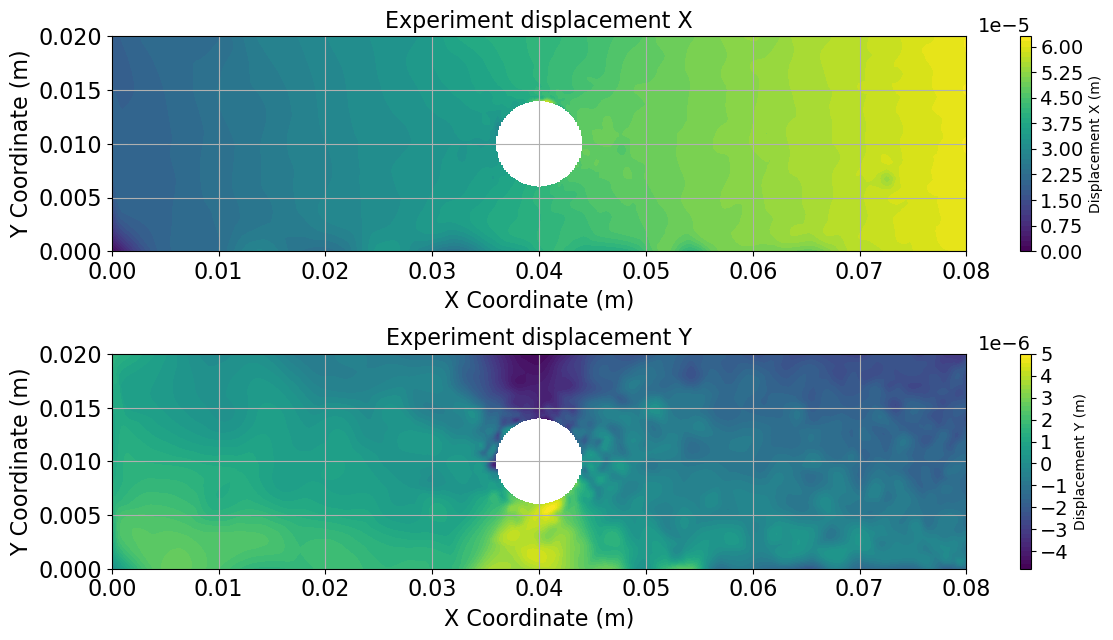

In [16]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
import os
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import griddata
raw = False
if raw:
    df = pd.read_csv(r"/home/narupanta/ADDMM/parameter_identification/11257192/20231116_displacements_raw.csv")
else :
    df = pd.read_csv(r"/home/narupanta/ADDMM/parameter_identification/11257192/20231116_displacements_raw.csv")
def remove_outliers_zscore(df, columns, threshold=3):
    """
    Removes outliers from specified columns in a DataFrame using the Z-score method.

    Parameters:
    - df: DataFrame from which to remove outliers.
    - columns: List of column names to check for outliers.
    - threshold: Z-score threshold to determine outliers (default is 3).

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    cleaned_df = df.copy()

    for column in columns:
        # Calculate the mean and standard deviation
        mean = cleaned_df[column].mean()
        std = cleaned_df[column].std()

        # Calculate the Z-score for each value in the column
        z_scores = (cleaned_df[column] - mean) / std

        # Filter out outliers based on the Z-score threshold
        cleaned_df = cleaned_df[(np.abs(z_scores) <= threshold)]

    return cleaned_df
def fill_na_with_neighbors(flattened_image, shape):
    rows, cols = shape
    for i in range(1, len(flattened_image) - 1):
        if np.isnan(flattened_image[i]):
            # Get the row and column indices of the pixel in the 2D image
            row = i // cols
            col = i % cols

            # Get the neighbors (left, right, top, bottom) in the flattened array
            neighbors = []
            if col > 0:  # Left neighbor
                neighbors.append(flattened_image[i - 1])
            if col < cols - 1:  # Right neighbor
                neighbors.append(flattened_image[i + 1])
            if row > 0:  # Top neighbor
                neighbors.append(flattened_image[i - cols])
            if row < rows - 1:  # Bottom neighbor
                neighbors.append(flattened_image[i + cols])

            # Remove NaN values from the neighbors list
            neighbors = [val for val in neighbors if not np.isnan(val)]

            # If there are valid neighbors, replace the NaN with the mean
            if neighbors:
                flattened_image[i] = np.mean(neighbors)
    
    return np.nan_to_num(flattened_image, nan = 0)

def mask_hole(X, Y) :
    center_x, center_y = 40e-3, 10e-3
    radius = 4e-3

    # Calculate the distance of each point from the center of the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Create a mask: True for points outside the circle, False for points inside
    return distance_from_center >= radius
def get_displacement_at_point(df, x, y, isClearOutlier):
    """
    Interpolates displacement data at a specified (x, y) point.

    Parameters:
    - df: DataFrame with columns ['x', 'y', 'displacement_x', 'displacement_y'].
    - x: float, x-coordinate of the point to interpolate.
    - y: float, y-coordinate of the point to interpolate.
    - method: Interpolation method (default is 'linear').

    Returns:
    - interpolated_displacement_x: Interpolated displacement_x value at the specified point.
    - interpolated_displacement_y: Interpolated displacement_y value at the specified point.
    """
    if isClearOutlier :
        df = remove_outliers_zscore(df, ['x-displacement [mm]', "y-displacement [mm]"], 3)
    # Extract points and displacement values from the DataFrame
    points = df[['x-coordinate [mm]', 'y-coordinate [mm]']].values/1000
    displacement_x = df['x-displacement [mm]'].values/1000
    displacement_y = df['y-displacement [mm]'].values/1000
    # Create interpolators for displacement_x and displacement_y
    interp_x = fill_na_with_neighbors(griddata(points, displacement_x, (x, y), method='linear'), points.shape)
    interp_y = fill_na_with_neighbors(griddata(points, displacement_y, (x, y), method='linear'), points.shape)
    return interp_x, interp_y
X, Y = observed_mesh_pos[:, 0], observed_mesh_pos[:, 1]
mask = mask_hole(X, Y)
Z_x = get_displacement_at_point(df, X, Y, True)[0]
Z_y = get_displacement_at_point(df, X, Y, True)[1]
X_train, Y_train =  np.where(mask, X, np.nan), np.where(mask, Y, np.nan)
Z_x_train = np.where(mask, Z_x, np.nan)
Z_y_train = np.where(mask, Z_y, np.nan)

# Apply mask: Set masked values to NaN
Z_x_plot = Z_x
Z_y_plot = Z_y
grid_x, grid_y = np.mgrid[np.min(X):np.max(X):500j, np.min(Y):np.max(Y):500j]
hole_center = (40e-3, 10e-3)
hole_radius = 4e-3
mask = np.sqrt((grid_x - hole_center[0])**2 + (grid_y - hole_center[1])**2) < hole_radius

# Apply mask (set values inside hole to NaN)
grid_z_x = griddata((X, Y), Z_x, (grid_x, grid_y), method='cubic')
grid_z_y = griddata((X, Y), Z_y, (grid_x, grid_y), method='cubic')
grid_z_x[mask] = np.nan
grid_z_y[mask] = np.nan
fig, ax = plt.subplots(2, 1, figsize=(12, 6.5))
# Subplot for displacement_x with masked values
contour_x = ax[0].contourf(grid_x, grid_y, grid_z_x, levels=50, cmap='viridis')
contour_y = ax[1].contourf(grid_x, grid_y, grid_z_y, levels=50, cmap='viridis')
cbar_x = fig.colorbar(contour_x, ax=ax[0], label='Displacement X (m)')
cbar_y = fig.colorbar(contour_y, ax=ax[1], label='Displacement Y (m)')
ax[0].set_title('Experiment displacement X', fontsize=16)
ax[0].set_xlabel('X Coordinate (m)', fontsize=16)
ax[0].set_ylabel('Y Coordinate (m)', fontsize=16)
ax[0].tick_params(axis='both', labelsize=16)
ax[0].grid(True)
ax[1].set_title('Experiment displacement Y', fontsize=16)
ax[1].set_xlabel('X Coordinate (m)', fontsize=16)
ax[1].set_ylabel('Y Coordinate (m)', fontsize=16)
ax[1].tick_params(axis='both', labelsize=16)
ax[1].grid(True)

# Display the plots
plt.tight_layout()
pdf_filename = f'exp_field_ondiscr.pdf'
with PdfPages(os.path.join("/home/narupanta/ADDMM/ADDMM/surrogate_model/output", pdf_filename)) as pp:
    pp.savefig(fig, bbox_inches='tight')  # Save with proper spacing
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
from matplotlib.backends.backend_pdf import PdfPages
def plot_compare_data(obs_mesh_pos, obs_fem_disp, exp_disp):
    X, Y = obs_mesh_pos[:, 0], obs_mesh_pos[:, 1]  # Assuming FEM displacement contains X, Y coordinates
    fem_Zx, fem_Zy = obs_fem_disp[:, 0], obs_fem_disp[:, 1]  # FEM displacement X and Y
    exp_Zx, exp_Zy = exp_disp[0], exp_disp[1]  # Experimental displacement X and Y

    # Compute error fields
    error_Zx = np.abs(fem_Zx - exp_Zx)
    error_Zy = np.abs(fem_Zy - exp_Zy)

    # Define grid for interpolation
    grid_x, grid_y = np.mgrid[np.min(X):np.max(X):500j, np.min(Y):np.max(Y):500j]

    # Define hole region (e.g., circular hole at center)
    hole_center = (40e-3, 10e-3)
    hole_radius = 4e-3
    mask = np.sqrt((grid_x - hole_center[0])**2 + (grid_y - hole_center[1])**2) < hole_radius

    # Interpolate values onto a structured grid
    grid_fem_Zx = griddata((X, Y), fem_Zx, (grid_x, grid_y), method='cubic')
    grid_fem_Zy = griddata((X, Y), fem_Zy, (grid_x, grid_y), method='cubic')
    grid_exp_Zx = griddata((X, Y), exp_Zx, (grid_x, grid_y), method='cubic')
    grid_exp_Zy = griddata((X, Y), exp_Zy, (grid_x, grid_y), method='cubic')
    grid_error_Zx = griddata((X, Y), error_Zx, (grid_x, grid_y), method='cubic')
    grid_error_Zy = griddata((X, Y), error_Zy, (grid_x, grid_y), method='cubic')

    # Apply mask to remove hole region
    for grid in [grid_fem_Zx, grid_fem_Zy, grid_exp_Zx, grid_exp_Zy, grid_error_Zx, grid_error_Zy]:
        grid[mask] = np.nan

    # Create figure and axis
    fig, ax = plt.subplots(3, 2, figsize=(20, 8))  # 3 Rows, 2 Columns

    # Titles for rows and columns
    row_titles = ["FEM displacement", "Experiment displacement", "Error Field"]
    col_titles = ["X [m]", "Y [m]"]

    # Data to plot
    grids = [[grid_fem_Zx, grid_fem_Zy], 
             [grid_exp_Zx, grid_exp_Zy], 
             [grid_error_Zx, grid_error_Zy]]

    # Plot each subplot
    for i in range(3):  # Rows
        for j in range(2):  # Columns
            contour = ax[i, j].contourf(grid_x, grid_y, grids[i][j], levels=50, cmap='viridis')
            cbar = fig.colorbar(contour, ax=ax[i, j])
            cbar.ax.tick_params(labelsize=14)
            
            # Set labels and titles
            ax[i, j].set_title(f"{row_titles[i]} {col_titles[j]}", fontsize=16)
            if i == 2 :
                ax[i, j].set_xlabel("X Coordinate [m]", fontsize=16)
            if j == 0 :
                ax[i, j].set_ylabel("Y Coordinate [m]", fontsize=16)
            ax[i, j].tick_params(axis='both', labelsize=14)
            ax[i, j].grid(True)

    # Adjust layout
    plt.tight_layout()
    pdf_filename = f'fem_vs_exp.pdf'
    with PdfPages(os.path.join("/home/narupanta/ADDMM/ADDMM/surrogate_model/output", pdf_filename)) as pp:
        pp.savefig(fig, bbox_inches='tight')  # Save with proper spacing

    plt.show()


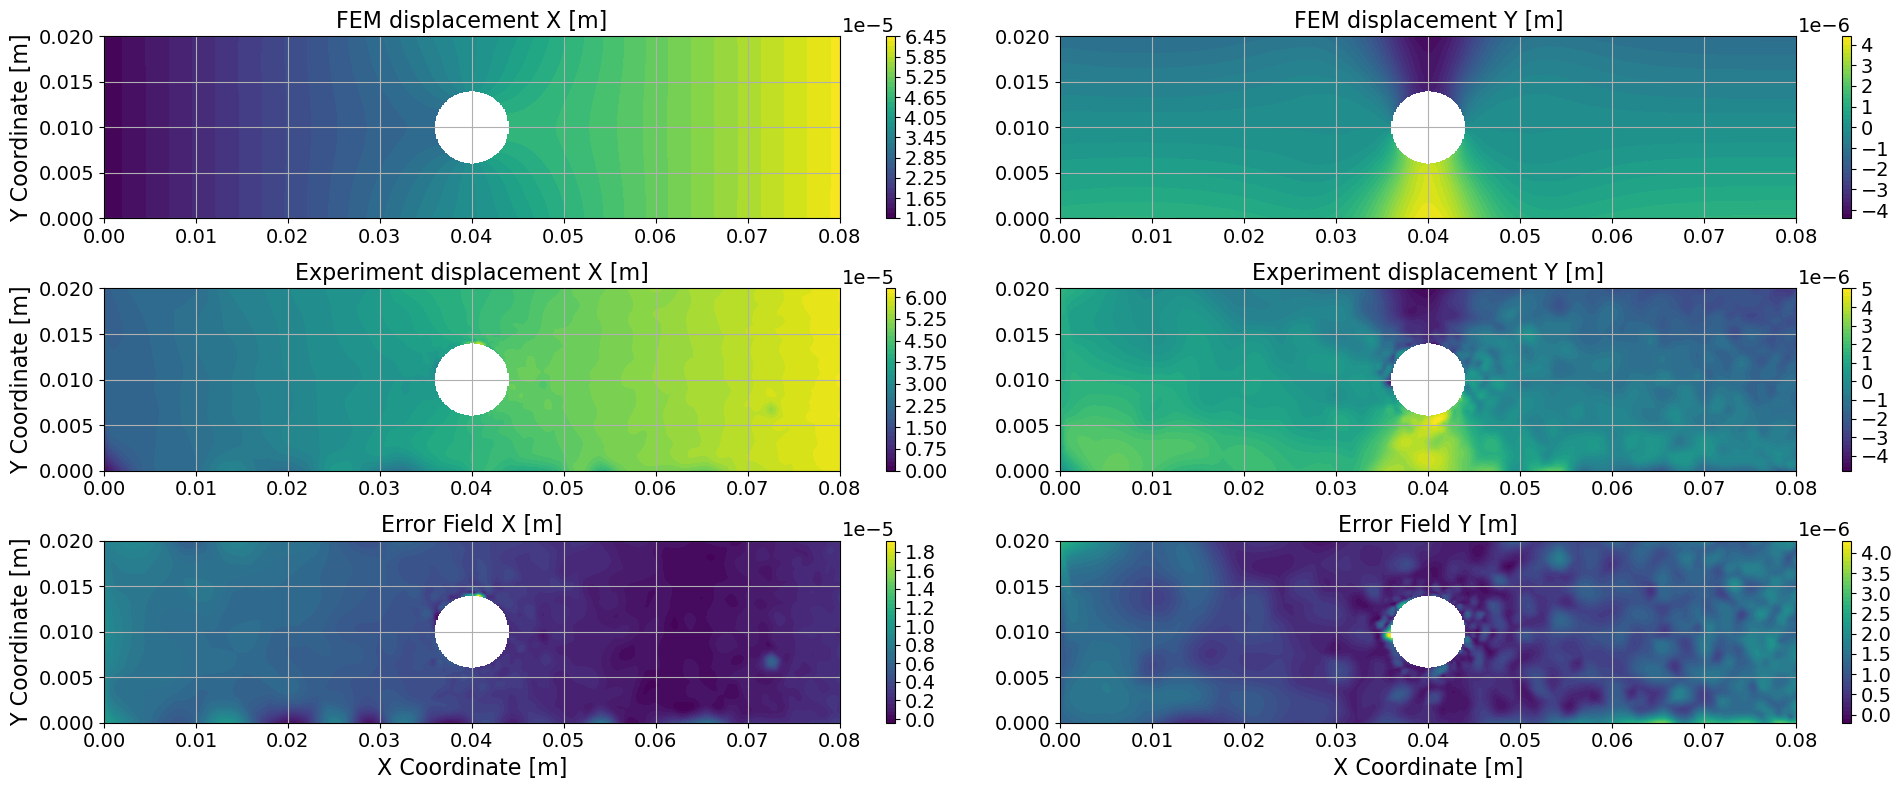

In [14]:
plot_compare_data(observed_mesh_pos, observed_displacement, [Z_x, Z_y])

In [7]:
from scipy.optimize import minimize
def callback(xk):
    print(f"Current solution: {xk}")

class OptimizationHistory:
    def __init__(self):
        self.history = []

    def __call__(self, xk):
        # Save current parameter values
        self.history.append(xk.copy())
def mse_loss(msh_data, train_ds, BETA) :
    G, K = BETA
    mesh_pos, node_connectivity, displacement = solve_fem(msh_data, G, K)
    observed_mesh_pos, observed_displacement = observer_operator(mesh_pos, displacement, observed_x_0, observed_y_0, observed_dx, observed_dy)
    radius = 4e-3 
    center_x, center_y = 40e-3, 10e-3
    distance_from_center = np.sqrt((observed_mesh_pos[:, 0] - center_x)**2 + (observed_mesh_pos[:, 1] - center_y)**2)
    distance_from_center_train = np.sqrt((train_ds[:, 0] - center_x)**2 + (train_ds[:, 1] - center_y)**2)
    train_disp_x = train_ds[:, 2][distance_from_center_train >= radius]
    train_disp_y = train_ds[:, 3][distance_from_center_train >= radius]
    fem_disp_x = observed_displacement[:, 0][distance_from_center >= radius]
    fem_disp_y = observed_displacement[:, 1][distance_from_center >= radius]
    mean_disp_x = np.mean(np.absolute(train_disp_x))
    mean_disp_y = np.mean(np.absolute(train_disp_y))
    Wx = 1/mean_disp_x
    Wy = 1/mean_disp_y
    err_norm_ux = np.linalg.norm(Wx * (train_disp_x - fem_disp_x))
    err_norm_uy = np.linalg.norm(Wy * (train_disp_y - fem_disp_y))
    result = (err_norm_ux**2 + err_norm_uy**2) * 0.5
    print(err_norm_ux, err_norm_uy) 
    # error_x_2 = np.sum((train_disp_x - fem_disp_x)**2, axis = 0)
    # error_y_2 = np.sum((train_disp_y - fem_disp_y)**2, axis = 0)
    # result = error_x_2 + error_y_2
    print(BETA, result) 
    return result
history = OptimizationHistory()
# Define constraint as a dictionary
train_ds = np.hstack((X.reshape(X.shape[0], 1), Y.reshape(Y.shape[0], 1), Z_x.reshape(Z_x.shape[0], 1), Z_y.reshape(Z_y.shape[0], 1)))
beta = [1e+9, 1e+9]
result = minimize(
    fun=lambda x: mse_loss(msh_data, train_ds, x),
    x0=beta,
    method='Nelder-Mead',
    callback=history
)

2344.6722001066514 2330.8797208825636
[1.e+09 1.e+09] 5465243.999587271
2268.3379640631365 2221.937230595141
[1.05e+09 1.00e+09] 5041181.08795745
2306.9099134213634 2329.0656269766196
[1.00e+09 1.05e+09] 5373190.021702878
2231.5466659203994 2218.41167763174
[1.05e+09 1.05e+09] 4950575.44681666
2178.930140020166 2166.101125272087
[1.075e+09 1.075e+09] 4719865.319996651
2146.88699337603 2076.2920386514065
[1.125e+09 1.025e+09] 4460056.196047192
2078.509087647097 1974.6176572884817
[1.1875e+09 1.0125e+09] 4109657.45995351
2000.3364804483836 1926.0826683541625
[1.2125e+09 1.0875e+09] 3855570.2401734586
1889.0001582446027 1806.360731543026
[1.29375e+09 1.13125e+09] 3415630.3451543953
1820.5645643362916 1683.4561901339566
[1.40625e+09 1.06875e+09] 3074240.038508664
1690.4784122361486 1530.0853378709664
[1.571875e+09 1.065625e+09] 2599439.2017020797
1559.7774773063106 1421.4425485169338
[1.678125e+09 1.184375e+09] 2226702.348723177
1388.2666748178751 1251.2662043564385
[1.9234375e+09 1.270312

In [8]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 211.07211544049662
             x: [ 7.391e+10  8.875e+10]
           nit: 133
          nfev: 293
 final_simplex: (array([[ 7.391e+10,  8.875e+10],
                       [ 7.391e+10,  8.875e+10],
                       [ 7.391e+10,  8.875e+10]]), array([ 2.111e+02,  2.111e+02,  2.111e+02]))